In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
!gdown https://drive.google.com/uc?id=1VKuCi2vNFZLhmyy2CdU0Lp8-Ab3re81N 
!gdown https://drive.google.com/uc?id=1JaF3TKLcveF2-88mzqF9EgP8928JhpCB
!gdown https://drive.google.com/uc?id=13ORjoqdKbALvDyVjPIq23HWleQhccafJ
!gdown https://drive.google.com/uc?id=1oijYQho6s63CjHppuJT7ERaRb81Javkt

Downloading...
From: https://drive.google.com/uc?id=1VKuCi2vNFZLhmyy2CdU0Lp8-Ab3re81N
To: /content/interactions_test.csv
100% 523k/523k [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JaF3TKLcveF2-88mzqF9EgP8928JhpCB
To: /content/interactions_train.csv.zip
100% 9.29M/9.29M [00:00<00:00, 19.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=13ORjoqdKbALvDyVjPIq23HWleQhccafJ
To: /content/RAW_interactions.csv.zip
100% 131M/131M [00:02<00:00, 45.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oijYQho6s63CjHppuJT7ERaRb81Javkt
To: /content/RAW_recipes.csv.zip
100% 87.3M/87.3M [00:01<00:00, 52.2MB/s]


In [3]:
! echo y | unzip RAW_interactions.csv.zip 
! echo y | unzip RAW_recipes.csv.zip
! echo y | unzip interactions_train.csv.zip

Archive:  RAW_interactions.csv.zip
  inflating: RAW_interactions.csv    
Archive:  RAW_recipes.csv.zip
  inflating: RAW_recipes.csv         
Archive:  interactions_train.csv.zip
  inflating: interactions_train.csv  


In [4]:
comments = pd.read_csv('RAW_interactions.csv')

In [5]:
comments.shape

(1132367, 5)

# Pré-traitement des données

On ajoute au trainset une occurence de chaque utilisateur et de chaque recette, puis le reste des notes est attribué aléatoirement au jeu de test et d'entrainement avec une proportion de 10% de jeu de test. 

In [6]:
#On ajoute au trainset une occurence de chaque utilisateur et de chaque 
#filter recipes
USER_ID = comments.user_id.unique()
RECIPE_ID = comments.recipe_id.unique()

trainset = comments[['user_id', 'recipe_id', 'rating']].groupby('user_id', as_index=False).first()
trainset = pd.concat([trainset, comments[['user_id', 'recipe_id', 'rating']].groupby('recipe_id', as_index=False).first()])

supp = pd.concat([trainset, comments[['user_id', 'recipe_id', 'rating']]]).drop_duplicates(keep=False)
testset = supp.sample(frac=0.1, replace=False)
add_on_trainset = supp[~supp.index.isin(testset.index)]
trainset = pd.concat([trainset, add_on_trainset])

In [7]:
trainset.head()

,user_id,recipe_id,rating,date,review
0,1533,116345,5,NaN,NaN
1,1535,349022,4,NaN,NaN
2,1581,341050,5,NaN,NaN
3,1634,16512,4,NaN,NaN
4,1676,34233,5,NaN,NaN


On vérifie que les individus et les recettes du jeu de test sont inclus dans le jeu d'entrainement

In [9]:
assert set(testset.user_id.unique()).issubset(trainset.user_id.unique())
assert set(testset.recipe_id.unique()).issubset(trainset.recipe_id.unique())

(152798, 5) (1736101, 5)


On convertit le dataset pandas en dataset Pytorch

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

user_list = trainset.user_id.unique()
item_list = trainset.recipe_id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, idx):
        user = user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating

trainloader = DataLoader(Ratings_Datset(trainset), batch_size=256, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Datset(testset), batch_size=64, num_workers=2)

# Définition du modèle 

On va approximer le produit vectoriel item-user par un réseau de neurones : ceci correspond au Neural Collaborative Filtering.

In [13]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean
import math



def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")


def test(model, testloader, m_eval=False):
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data
            
            running_mae += error
            total += y.size(0)
    
    mae = running_mae/total
    return mae * 5

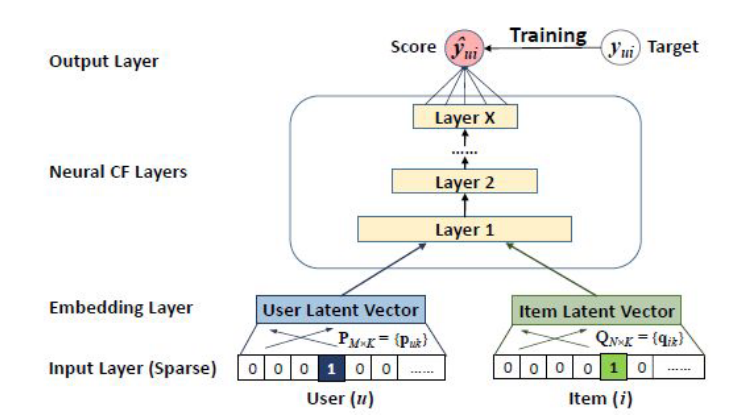

In [14]:
import torch.nn as nn
import torch


class NCF(nn.Module):
    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = nn.Embedding(n_users, n_factors)
        self.item_embeddings = nn.Embedding(n_items, n_factors)
        self.predictor = nn.Sequential(
            nn.Linear(in_features=n_factors * 2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid(),
        )

    def forward(self, user, item):

        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)


# Entrainement du modèle 

In [16]:
n_user = trainset.user_id.nunique()
n_items = trainset.recipe_id.nunique()
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(  ), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

# Evaluation du jeu de test 

In [17]:
test(model, testloader)

tensor(0.6236, device='cuda:0')

In [18]:
users, recipes, r = next(iter(testloader))
users = users.cuda()
recipes = recipes.cuda()
r = r.cuda()

y = model(users, recipes)*5
print("ratings", r[:40].data)
print("predictions:", y.flatten()[:40].data)

ratings tensor([5., 5., 0., 5., 4., 4., 4., 4., 5., 4., 5., 5., 5., 5., 5., 5., 3., 5.,
        5., 4., 3., 5., 5., 5., 2., 4., 5., 5., 5., 5., 5., 5., 4., 5., 5., 2.,
        5., 5., 4., 5.], device='cuda:0')
predictions: tensor([4.9598, 4.9999, 1.6000, 4.6001, 4.2796, 4.0272, 4.8910, 4.7032, 4.8257,
        4.7349, 4.6900, 4.9935, 4.9388, 4.9730, 4.8826, 4.5736, 4.6074, 4.7721,
        4.7324, 4.3371, 2.9173, 4.3404, 4.6815, 4.9158, 1.0770, 4.4157, 3.8763,
        4.5519, 4.8872, 4.7750, 4.9831, 4.8013, 4.9259, 4.9681, 4.9414, 0.6186,
        4.8280, 4.2789, 4.6099, 3.1430], device='cuda:0')


# Enregistrement des poids du modèle

In [19]:
torch.save([model.state_dict(), {'item_list' : item_list}, {'user_list' : user_list}], "weight.pth")